In [1]:
import idx2numpy
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
#Set device
#if cuda is available then use cuda, else use cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#declare parameters

input_size = 784 #image size = 28x28 --flatten 784
n_classes = 10
n_epoch = 2
batch_size = 100
learning_rate = 0.001

In [4]:
#unzip dataset to test_images, test_labels, train_images, train_labels as numpy

file = r'/home/zacharyyeh/Datasets/MNIST/t10k-images.idx3-ubyte'
test_images = idx2numpy.convert_from_file(file)
file = r'/home/zacharyyeh/Datasets/MNIST/t10k-labels.idx1-ubyte'
test_labels = idx2numpy.convert_from_file(file)
file = r'/home/zacharyyeh/Datasets/MNIST/train-images.idx3-ubyte'
train_images = idx2numpy.convert_from_file(file)
file = r'/home/zacharyyeh/Datasets/MNIST/train-labels.idx1-ubyte'
train_labels = idx2numpy.convert_from_file(file)

In [5]:
#Build children class TrainSet, TestSet from parent class Dataset 

class TrainSet(Dataset):
    def __init__(self, transform = None):
        self.train_images = train_images
        self.train_labels = train_labels
        self.n_samples = train_images.shape[0]
        #Important!!!! add a channel to images [28, 28] to [1, 28, 28] so that i can be seen as a image
        self.train_images = np.resize(self.train_images, (self.n_samples, 1, 28,28))
        #Transpouse to fit ToTensor input form!!!! [samples c h w] to [samples h w c]
        self.train_images = np.transpose(self.train_images, (0, 2, 3, 1))
        self.transform = transform

    def __getitem__(self, index):
        img, target = self.train_images[index], self.train_labels[index]
        if self.transform:
            img = self.transform(img)
        return img, target

    def __len__(self):
        return self.n_samples

class TestSet(Dataset):
    def __init__(self, transform = None):
        self.test_images = test_images
        self.test_labels = test_labels
        self.n_samples = test_images.shape[0]
        self.test_images = np.resize(self.test_images, (self.n_samples, 1, 28,28))
        self.test_images = np.transpose(self.test_images, (0, 2, 3, 1))
        self.transform = transform

    def __getitem__(self, index):
        img, target = self.test_images[index], self.test_labels[index]
        if self.transform:
            img = self.transform(img)
        return img, target

    def __len__(self):
        return self.n_samples


#Make dataset with transform included

composed = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = (0.5,), std = (0.5,))])

train_dataset = TrainSet(transform = composed)
test_dataset = TestSet(transform = composed)

#Make dataloader
#Note: DataLoader antomatically transform data from numpy to tensor
#But we still do ToTensor transform to Normalize(normalize require tensor dtype)
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = 10, shuffle = False)

torch.Size([10, 1, 28, 28])


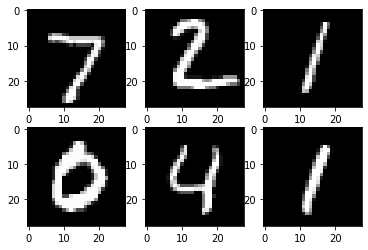

In [6]:
#Show some examples to examinate dataloader

examples = iter(test_loader)
example_data, example_targets = examples.next()
print(example_data.shape)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0] , cmap='gray')
plt.show()

In [7]:
#Build a Convolutional Neural Network

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.Conv = nn.Conv2d(in_channels =1, out_channels = 10, kernel_size = 3, stride = 1, padding = 1)
        self.ReLU = nn.ReLU()
        self.MaxPool = nn.MaxPool2d(2)
        self.Linear = nn.Linear(in_features = 1960 , out_features= 10)
    
    def forward(self, x):
        output = self.Conv(x) #input(batch_size ,1, 28, 28), output(batch_size, 10, 28, 28)
        output = self.ReLU(output)
        output = self.MaxPool(output) #input(batch_size, 10, 28, 28), output(batch_size, 10, 14, 14)
        #flatten input(batch_size, 10, 14, 14), output(batch_size, 1960)
        output = output.view(-1, 1960)
        #Linear input(bath_size, 1960) output(batch_size, 10)
        output = self.Linear(output)
        #we don't have to do softmax here, because we are use CrossEntropy, which softmax is included
        return output

model = Model().to(device)
print(model)

Model(
  (Conv): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU): ReLU()
  (MaxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Linear): Linear(in_features=1960, out_features=10, bias=True)
)


In [8]:
#Define loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [9]:
#Make Training Loop

steps = len(train_loader)

print('Start training...')

for epoch in range(n_epoch):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        #Note: Labels are now dtype torch.uint8, should be change to torch.long for CrossEntropyLoss
        labels = labels.type(torch.long)
        labels = labels.to(device)
        #forward pass
        pred_labels = model(images)
        loss = criterion(pred_labels, labels)

        #backward pass
        loss.backward()

        #update gradients
        optimizer.step()
        optimizer.zero_grad()

        #print information in a epoch
        if (i+1) % 100 == 0:
            print(f'epoch: {epoch+1}/{n_epoch}, step: {(i+1)}/{steps}, loss: {loss.item():.3f}')

            
print('Training is completed')

Start training...
epoch: 1/2, step: 100/600, loss: 0.400
epoch: 1/2, step: 200/600, loss: 0.245
epoch: 1/2, step: 300/600, loss: 0.190
epoch: 1/2, step: 400/600, loss: 0.218
epoch: 1/2, step: 500/600, loss: 0.090
epoch: 1/2, step: 600/600, loss: 0.163
epoch: 2/2, step: 100/600, loss: 0.131
epoch: 2/2, step: 200/600, loss: 0.100
epoch: 2/2, step: 300/600, loss: 0.071
epoch: 2/2, step: 400/600, loss: 0.119
epoch: 2/2, step: 500/600, loss: 0.074
epoch: 2/2, step: 600/600, loss: 0.095
Training is completed


In [10]:
#Test the model

#Note: In test case, we do not want to calculate the gradients
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    #you can also use for i, (images, labels) in enumerate(test_loader):
    #but now we don't care batch imformation, simple use this
    for images, labels in test_loader:
        #flatten
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        #the output is a probability distribution. We want to tranform them into integer(predicted state)
        #torch.max(tensor, dimention) will return [max tensor value, index] in a dimention of a tensor
        #here we only want the index, not the linear output(float), actually it is the predicted number
        #Note: _ here is not probability because we didn't apply softmax
        _, predicted = torch.max(output, 1)
        n_samples = n_samples + labels.shape[0]
        #Note (predicted == labels) is still a tensor with one element. We need to use item() to get a value
        #then we can compute divition
        n_correct = n_correct + (predicted == labels).sum().item()

acc = n_correct / n_samples
print(f'model accuracy: {acc:.3f}')

model accuracy: 0.972


In [11]:
#See some predictions of the model

with torch.no_grad():
    examples = iter(test_loader)
    data, actual_labels = examples.next()
    data = data.to(device)
    predicted_labels = model(data)
    _, predicted_labels = torch.max(predicted_labels, 1)

print('predicted labels:\n', predicted_labels.cpu().numpy())
print('actual labels:\n', actual_labels.numpy().squeeze())



predicted labels:
 [7 2 1 0 4 1 4 9 6 9]
actual labels:
 [7 2 1 0 4 1 4 9 5 9]
